# 7. 인물사진을 만들어 보자

## 모델 및 데이터 준비
사진에서 인물과 배경을 분리하기 위해 Semantic Segmentation을 적용할 것이고, 이를 위해 이미 훈련되어 있는 모델을 활용합니다.
- 사용된 모델은 DeepLabV3입니다.
  - 해당 모델은 PixelLib에서 제공합니다.
  - 해당 모델은 PASCAL VOC 데이터셋을 사용하여 훈련되었습니다.

In [1]:
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

model_file = "models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
model_url = "https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"

urllib.request.urlretrieve(model_url, model_file)


('models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x23b849db130>)

앞서 준비한 학습이 완료된 모델 파일을 사용하여 모델을 준비합니다.

In [2]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

해당 모델은 총 21개의 라벨 데이터를 가지고 있습니다.

In [3]:
LABEL_NAMES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tv",
]
len(LABEL_NAMES)


21

사용하고자 하는 이미지를 불러옵니다.

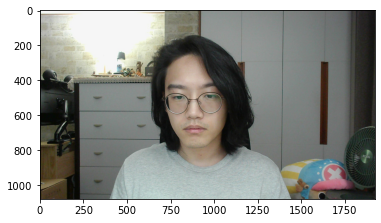

In [4]:
img_path = "images/face1.jpg"
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


불러온 모델을 사용하여 segmentation 결과를 확인합니다.

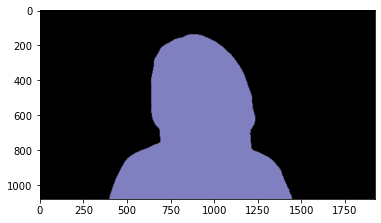

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()


어떤 클래스들이 검출되었는지 확인합니다.

In [6]:
segvalues
for class_id in segvalues["class_ids"]:
    print(LABEL_NAMES[class_id])


background
person


해당 이미지에서는 총 2개의 클래스가 검출되었습니다.
- `background`
- `person`

각 클래스를 구분하기 편하도록 색상 정보를 담고 있는 `colormap`을 생성합니다.

In [7]:
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]


array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

찾고자 하는 `person` 클래스에 해당하는 15번째 항목을 확인합니다.

In [8]:
colormap[15]


array([192, 128, 128])

확인된 `colormap`에 해당하는 부분을 이미지로 출력합니다.

(1080, 1920)


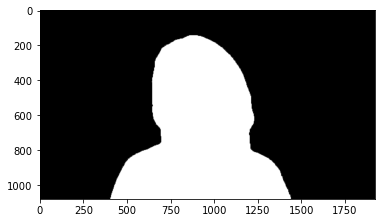

In [9]:
seg_color = colormap[15][::-1]
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap="gray")
plt.show()


원본 이미지 위에 `person` 클래스에 해당 하는 영역을 출력합니다.

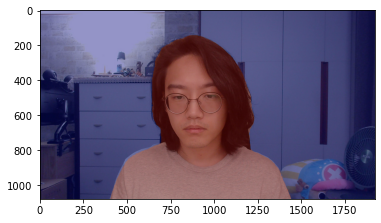

In [10]:
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


배경과 사람 영역에 대한 분리는 완료되었으니, 전체 이미지를 흐리게 만들어 줍니다.

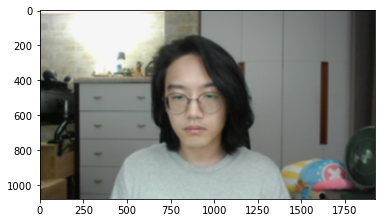

In [11]:
img_orig_blur = cv2.blur(img_orig, (13, 13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()


흐린 이미지에서 사람 영역을 제거합니다.

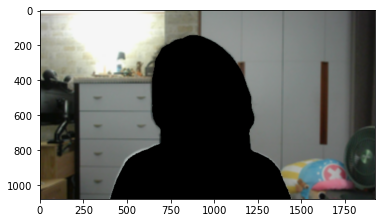

In [12]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


앞서 생성한 사람 영역을 기준으로, 흐려진 이미지에 사람을 합성합니다.

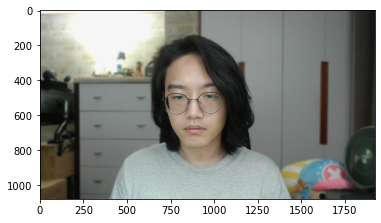

In [13]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


## 배경 흐리게

사람을 제외한 나머지 영역이 자연스럽게 흐려진 결과를 확인할 수 있습니다.  
위의 과정을 수행할 수 있는 함수를 작성하여 다른 이미지에 대해서도 테스트를 진행합니다.

In [14]:
def blur_bg(img_path, class_num=15):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    img_orig = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

    _, output = model.segmentAsPascalvoc(img_path)
    if img_orig.shape[0] != output.shape[0]:
        output = np.rot90(output, k=-1)
    plt.subplot(1, 4, 2)
    plt.imshow(output)

    img_show = img_orig.copy()
    seg_color = colormap[class_num][::-1]
    seg_map = np.all(output == seg_color, axis=-1)
    img_mask = seg_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

    img_orig_blur = cv2.blur(img_orig, (13, 13))
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, ~img_mask_color)
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()


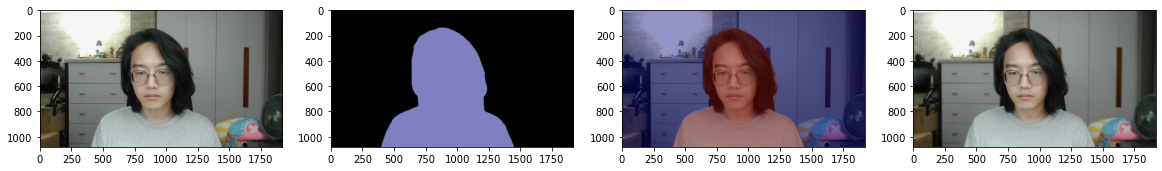

In [15]:
blur_bg("images/face1.jpg")


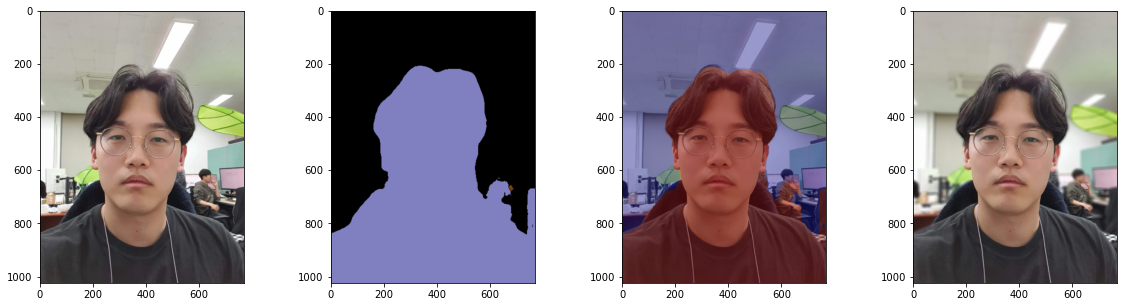

In [16]:
blur_bg("images/face2.jpg")


원하는 사람 영역은 잘 검출하였으나, 사람이 아닌 불필요한 영역에 대해서도 검출 결과가 존재합니다.  
해당 영역에 대한 처리가 필요해 보입니다.

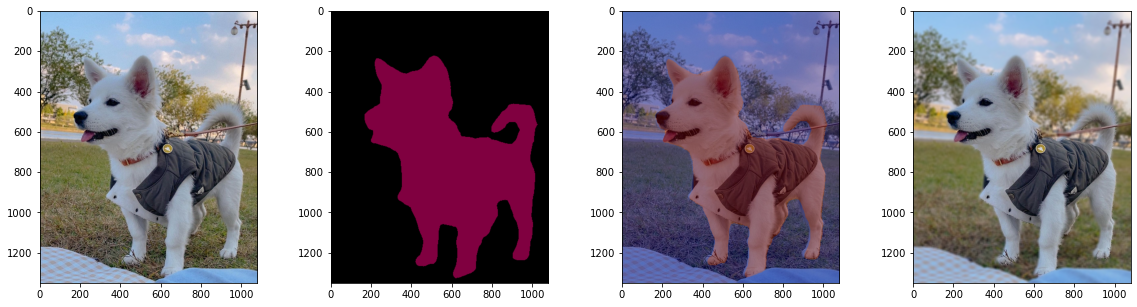

In [17]:
blur_bg("images/dog1.jpg", class_num=12)


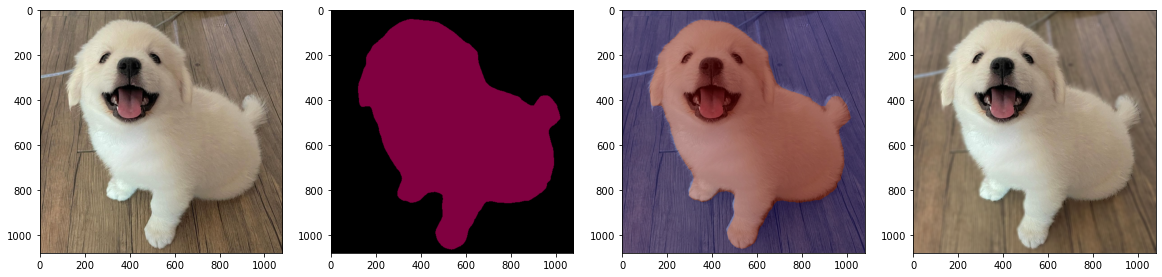

In [18]:
blur_bg("images/dog2.jpg", class_num=12)


강아지 사진에 대해서는 불필요한 영역 검출 없이 "배경 흐리게"가 잘 적용되었습니다.

## 배경 교체
배경을 흐리게 만드는 함수를 응용하여 배경을 변경하는 함수를 작성합니다.

In [19]:
def change_bg(img_path1, img_path2, class_num=15):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    img_src = cv2.imread(img_path1)
    plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))

    _, output = model.segmentAsPascalvoc(img_path1)
    if img_src.shape[0] != output.shape[0]:
        output = np.rot90(output, k=-1)
    plt.subplot(1, 3, 2)
    plt.imshow(output)

    seg_color = colormap[class_num][::-1]
    seg_map = np.all(output == seg_color, axis=-1)
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    img_dst = cv2.imread(img_path2)
    img_dst_res = cv2.resize(img_dst, img_src.shape[:2][::-1])
    img_res = np.where(img_mask_color == 255, img_src, img_dst_res)
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))
    plt.show()


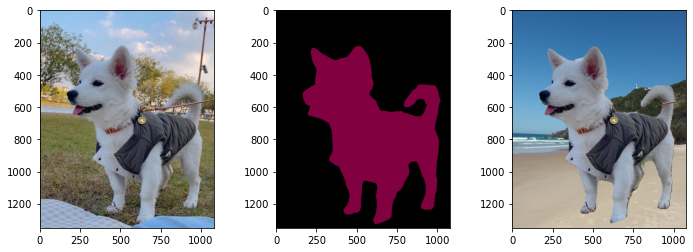

In [20]:
change_bg("images/dog1.jpg", "bg/bg1.jpg", class_num=12)


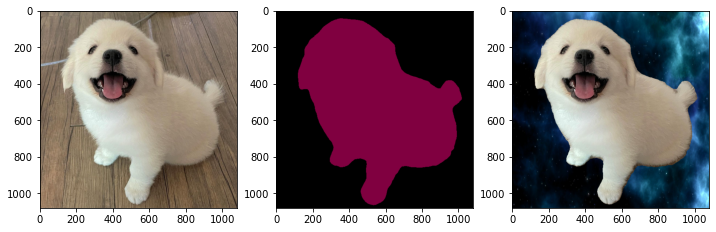

In [21]:
change_bg("images/dog2.jpg", "bg/bg2.jpg", class_num=12)


배경을 교체하는 작업도 정상적으로 수행되었습니다.  
전경에 있는 객체를 잘 검출하면 "배경 흐리게" 또는 "배경 교체"가 자연스럽게 잘 적용됩니다.

## 깊이 추정
앞선 코드에서 두 번째 인물 사진은 다른 사진과 비교하여 결과가 정교하지 못하였습니다.  
![fault](img/e07_faulty.png)

해당 문제를 해결하기 위해 깊이 정보를 활용하고자 합니다.  
깊이 정보는 하나의 카메라 이미지에서 깊이를 추정하는 Monocular Depth Estimation을 이용하여 획득합니다.
- 사전에 학습이 완료되어 PyTorch Hub에 공개되어 있는 모델을 사용하였습니다.
- [Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://github.com/isl-org/MiDaS)

In [22]:
import cv2
import torch

import matplotlib.pyplot as plt

# MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Large"
# MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "DPT_Hybrid"
# MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
# model_type = "MiDaS_small"

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform



Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to C:\Users\jhoon/.cache\torch\hub\master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to C:\Users\jhoon/.cache\torch\hub\checkpoints\dpt_large-midas-2f21e586.pt
100%|██████████| 1.28G/1.28G [03:46<00:00, 6.08MB/s]  
Using cache found in C:\Users\jhoon/.cache\torch\hub\intel-isl_MiDaS_master


깊이 정보를 획득할 이미지를 준비합니다.

In [23]:
img = cv2.imread("images/face1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)


모델을 사용하여 깊이 정보를 추정합니다.

In [24]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()


C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


대부분의 전경 요소들은 배경 요소와 비교하여 상대적으로 가까운 거리에 존재하기 때문에, 상위 50%의 거리 정보만 남겨두고 나머지는 버립니다.

In [25]:
thr = np.quantile(output, 0.50)
output_thr = output.copy()
output_thr[output < thr] = 0


위의 과정을 통해 가까운 50%의 정보만 남기면 다음과 같습니다.

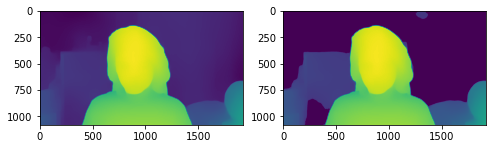

In [26]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(output)
plt.subplot(1, 2, 2)
plt.imshow(output_thr)
plt.show()


깊이 정보가 성공적으로 추출됨을 확인하였으니, 함수로 작성하여 여러 이미지에 대하여 테스트를 진행합니다.

In [27]:
def get_depth(img_path, threshold=0.5, debug=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()

    thr = np.quantile(output, threshold)
    output_thr = output.copy()
    output_thr[output < thr] = 0
    output_bin = output_thr.astype(np.uint8)
    output_bin[output_bin > 1] = 255

    if debug:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(output)
        plt.subplot(1, 3, 2)
        plt.imshow(output_thr)
        plt.subplot(1, 3, 3)
        plt.imshow(output_bin)
        plt.show()
    return output_bin


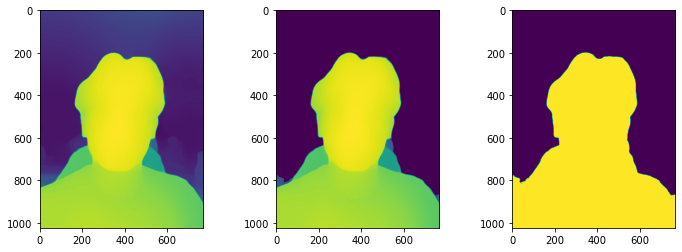

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [28]:
get_depth("images/face2.jpg", debug=True)


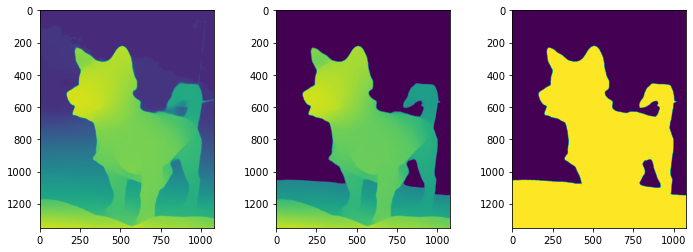

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [29]:
get_depth("images/dog1.jpg", debug=True)


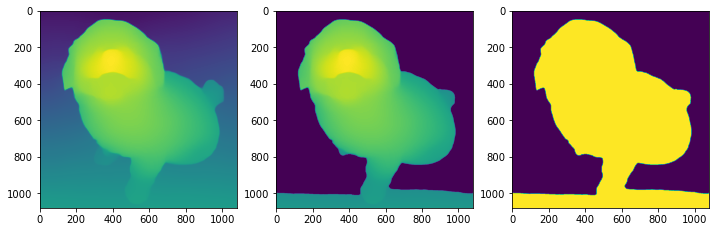

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [30]:
get_depth("images/dog2.jpg", debug=True)


사람과 강아지 모두에 대해서 거리 검출이 성공적으로 이루어졌고, 가장 가까운 50%의 거리 정보만을 남겨두었습니다.

## 깊이 정보를 활용한 Segmentation 결과 보정
깊이 정보를 활용하여 세그멘테이션 결과를 보정하는 함수를 작성합니다.  
함수가 동작하는 순서는 다음과 같습니다.  
1. segmentation 수행
2. depth estimation 수행
3. segmentation 결과와 depth estimation의 결과가 모두 존재하는 영역 검출
4. 3번의 과정에서 얻은 영역을 최종 전경으로 사용하여 "배경 흐리게" 적용

In [31]:
def blur_bg_seg(img_path, class_num=15):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 6, 1)
    img_orig = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

    _, output = model.segmentAsPascalvoc(img_path)
    if img_orig.shape[0] != output.shape[0]:
        output = np.rot90(output, k=-1)
    plt.subplot(1, 6, 2)
    plt.imshow(output)

    depth_map = get_depth(img_path)
    plt.subplot(1, 6, 3)
    plt.imshow(depth_map)

    seg_color = colormap[class_num][::-1]
    seg_map = np.all(output == seg_color, axis=-1)
    img_mask = seg_map.astype(np.uint8) * 255
    mask_xor = cv2.bitwise_xor(img_mask, depth_map)
    plt.subplot(1, 6, 4)
    plt.imshow(cv2.cvtColor(mask_xor, cv2.COLOR_GRAY2BGR))

    mask_combined = cv2.bitwise_and(img_mask, depth_map)
    plt.subplot(1, 6, 5)
    plt.imshow(cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR))

    img_orig_blur = cv2.blur(img_orig, (13, 13))
    img_mask_color = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, ~img_mask_color)
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
    plt.subplot(1, 6, 6)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()


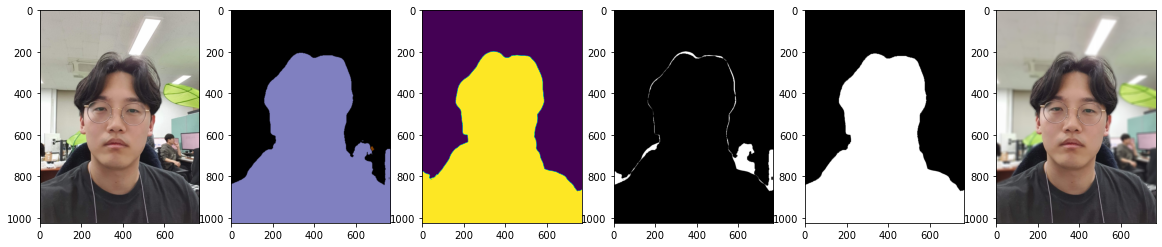

In [32]:
blur_bg_seg("images/face2.jpg")

가장 좌측의 사진부터
1. 입력 이미지
2. segmentation 결과
3. depth estimation을 통해 얻은 특정 거리 이내의 결과
4. segmentation의 결과와 depth estimation의 결과에서 일치하지 않는 부분
5. **segmentation의 결과와 depth estimation의 결과가 일치하는 부분**
6. 5번의 정보를 이용하여 "배경 흐리게"를 적용한 결과

깊이 정보를 이용하여 이전에 관측되었던 문제점을 해결할 수 있었습니다.

## 결론
- Segmentation 결과를 사용하여 아웃포커싱 효과와 배경 전환 효과를 적용할 수 있었습니다.
- Segmentation의 결과에 따라 자연스럽지 못한 결과가 나타나는 경우가 존재합니다.
- 문제가 있는 경우를 보완하기 위해 추가적으로 Depth estimation 정보를 사용하였고, 조금 더 자연스러운 사진 효과를 얻을 수 있었습니다.

## 루브릭
| 평가문항 | 상세기준 |
| --- | --- |
| 1. 인물모드 사진을 성공적으로 제작하였다. | 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다. |
| 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다. | 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다. |
| 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. | 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다. |

### 루브릭 자체 평가
1. 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 강아지 사진, 배경전환 사진을 각각 2장, 2장, 2장씩 제작하였다.
2. 인물사진에서 발생한 문제점을 확인하였다.
3. segmentation 정보와 더불어 depth 정보를 활용하여 segmentation의 결과를 보완할 수 있는 방법을 제시하였다.

## 사진 출처
- 강아지[(일리온나 인스타그램)](https://www.instagram.com/illy_onna/)